In [11]:
# ==============================
# 📘 Malawi Stock Exchange Analysis
# ==============================

# Install missing plotting libraries (use magic so it runs in the notebook environment)
%pip install matplotlib seaborn --quiet

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Load Data ---
conn = sqlite3.connect("mse_data.db")
df = pd.read_sql("SELECT * FROM daily_prices", conn)
conn.close()

print("✅ Data loaded successfully!")
print(df.head())
print(df.tail())


Note: you may need to restart the kernel to use updated packages.
✅ Data loaded successfully!
   Symbol Open Price Close Price % Change  Volume Turnover (MK) scrape_date
0  AIRTEL     130.00      129.97        0   17486    2272741.00  2025-05-16
1     BHL      15.04       15.04        0  151584    2279823.00  2025-05-16
2    FDHB     637.58      637.55        0  222098  141598900.00  2025-05-16
3   FMBCH    2887.66     2887.66        0   35632  102893200.00  2025-05-16
4    ICON      17.95       17.95        0   63538    1140507.00  2025-05-16
                             Symbol                      Open Price  \
114                             PCL                         8728.56   
115                        STANDARD                         4976.14   
116                         SUNBIRD                          632.61   
117                             TNM                           31.67   
118  Stats as at 11/11/2025 17:00pm  Stats as at 11/11/2025 17:00pm   

                       

In [2]:
print(df.columns)

Index(['Symbol', 'Open Price', 'Close Price', '% Change', 'Volume',
       'Turnover (MK)', 'scrape_date'],
      dtype='object')


In [3]:
# --- 2️⃣ Clean Data ---

df['scrape_date'] = pd.to_datetime(df['scrape_date'])
df = df.sort_values(['Symbol', 'scrape_date'])

# Convert numeric fields
df['Close Price'] = pd.to_numeric(df['Close Price'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

# Drop missing price rows
df.dropna(subset=['Close Price'], inplace=True)

print("✅ Data cleaned and formatted.")
df.info()


✅ Data cleaned and formatted.
<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 0 to 117
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Symbol         112 non-null    object        
 1   Open Price     112 non-null    object        
 2   Close Price    112 non-null    float64       
 3   % Change       112 non-null    object        
 4   Volume         112 non-null    float64       
 5   Turnover (MK)  112 non-null    object        
 6   scrape_date    112 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 7.0+ KB


In [16]:
# --- 3️⃣ Calculate Key Metrics (Updated for Pandas 2.2+) ---

# Ensure numeric types for calculations
df['Close Price'] = pd.to_numeric(df['Close Price'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')


# ✅ Daily % Change (safe for new pandas versions)
df['Daily_Return_%'] = (
    df.groupby('Symbol', group_keys=False)['Close Price']
      .apply(lambda x: x.diff() / x.shift() * 100)
)

# ✅ 20-day Moving Average
df['MA_20'] = (
    df.groupby('Symbol', group_keys=False)['Close Price']
      .apply(lambda x: x.rolling(20, min_periods=1).mean())
)

# ✅ Rolling 20-day Volatility (standard deviation of returns)
df['Volatility_20'] = (
    df.groupby('Symbol', group_keys=False)['Daily_Return_%']
      .apply(lambda x: x.rolling(20, min_periods=1).std())
)

# ✅ Cumulative Return (from first recorded day)
df['Cumulative_Return'] = (
    df.groupby('Symbol', group_keys=False)['Close Price']
      .apply(lambda x: x / x.iloc[0] - 1)
)

# ✅ 7-day Volume Trend
df['Vol_MA_7'] = (
    df.groupby('Symbol', group_keys=False)['Volume']
      .apply(lambda x: x.rolling(7, min_periods=1).mean())
)

print("✅ Metrics calculated successfully (Pandas 2.2+ compatible)!")
df.head()


✅ Metrics calculated successfully (Pandas 2.2+ compatible)!


,Symbol,Open Price,Close Price,% Change,Volume,Turnover (MK),scrape_date,Daily_Return_%,MA_20,Volatility_20,Cumulative_Return,Vol_MA_7
0,AIRTEL,130.00,129.97,0,17486.0,2272741.00,2025-05-16,NaN,129.97,NaN,0.0,17486.0
1,BHL,15.04,15.04,0,151584.0,2279823.00,2025-05-16,NaN,15.04,NaN,0.0,151584.0
2,FDHB,637.58,637.55,0,222098.0,141598900.00,2025-05-16,NaN,637.55,NaN,0.0,222098.0
3,FMBCH,2887.66,2887.66,0,35632.0,102893200.00,2025-05-16,NaN,2887.66,NaN,0.0,35632.0
4,ICON,17.95,17.95,0,63538.0,1140507.00,2025-05-16,NaN,17.95,NaN,0.0,63538.0


In [5]:
# --- 4️⃣ Save Output to Excel ---
df.to_excel("mse_analysis_output.xlsx", index=False)
print("💾 Results saved to 'mse_analysis_output.xlsx'")


💾 Results saved to 'mse_analysis_output.xlsx'


In [6]:
# --- 5️⃣ Visualization: Setup ---
sns.set(style="whitegrid", palette="tab10")

example_ticker = df['Symbol'].unique()[0]
ticker_df = df[df['Symbol'] == example_ticker]

print(f"📊 Example Ticker: {example_ticker}")


📊 Example Ticker: AIRTEL


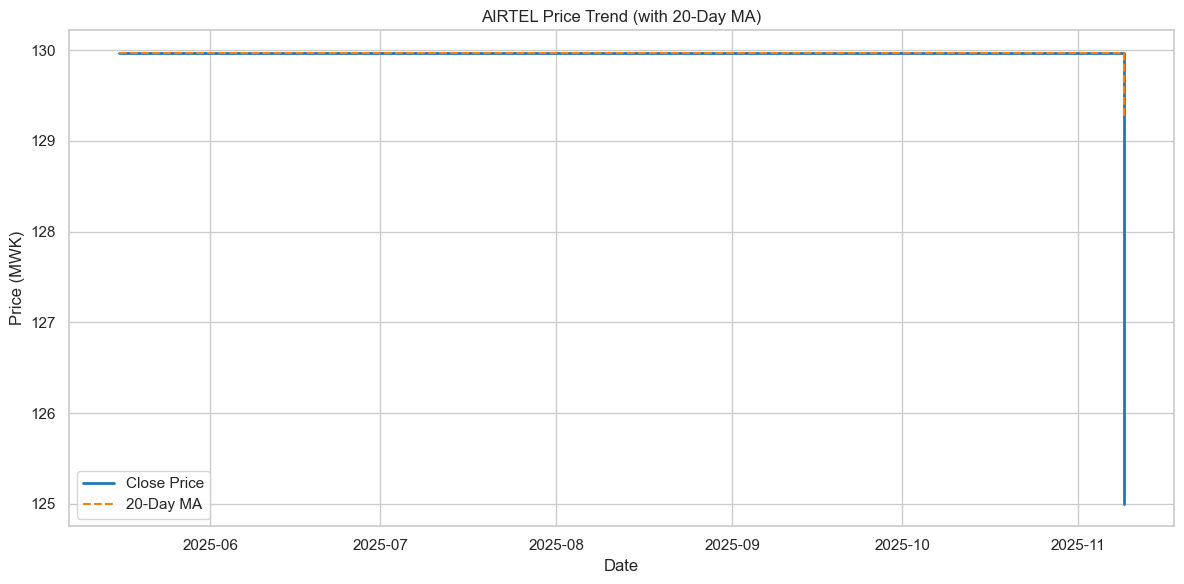

In [7]:
# --- 6️⃣ Plot: Closing Price & Moving Average ---
plt.figure(figsize=(12,6))
plt.plot(ticker_df['scrape_date'], ticker_df['Close Price'], label="Close Price", linewidth=2)
plt.plot(ticker_df['scrape_date'], ticker_df['MA_20'], label="20-Day MA", linestyle="--")
plt.title(f"{example_ticker} Price Trend (with 20-Day MA)")
plt.xlabel("Date")
plt.ylabel("Price (MWK)")
plt.legend()
plt.tight_layout()
plt.show()


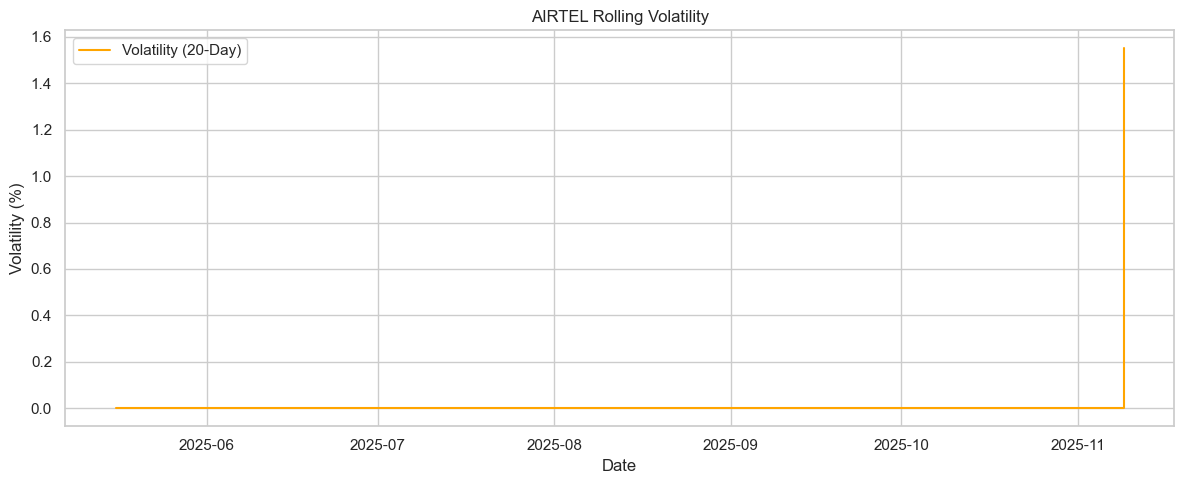

In [8]:
# --- 7️⃣ Plot: Volatility (20-Day Rolling) ---
plt.figure(figsize=(12,5))
plt.plot(ticker_df['scrape_date'], ticker_df['Volatility_20'], color="orange", label="Volatility (20-Day)")
plt.title(f"{example_ticker} Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.tight_layout()
plt.show()


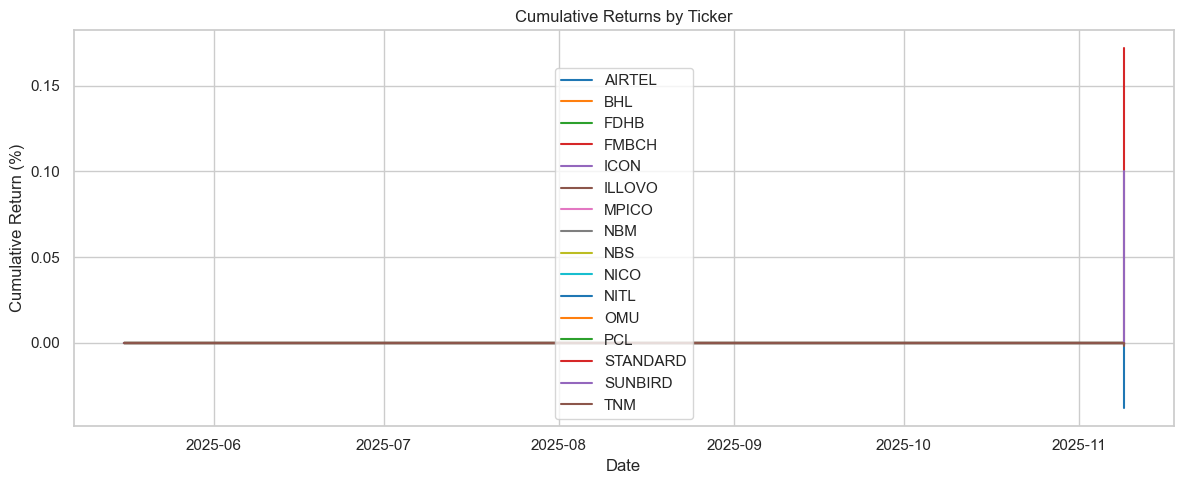

In [9]:
# --- 8️⃣ Plot: Cumulative Returns (All Tickers) ---
plt.figure(figsize=(12,5))
for ticker in df['Symbol'].unique():
    temp = df[df['Symbol'] == ticker]
    plt.plot(temp['scrape_date'], temp['Cumulative_Return'], label=ticker)

plt.title("Cumulative Returns by Ticker")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# --- 9️⃣ Summary Performance Table ---
summary = df.groupby('Symbol').agg({
    'Daily_Return_%': 'mean',
    'Volatility_20': 'mean',
    'Cumulative_Return': 'last',
    'Volume': 'mean'
}).rename(columns={
    'Daily_Return_%': 'Avg Daily Return (%)',
    'Volatility_20': 'Avg Volatility (%)',
    'Cumulative_Return': 'Total Return',
    'Volume': 'Avg Volume'
}).reset_index()

print("📋 === Summary Performance ===")
display(summary.round(2))


📋 === Summary Performance ===


,Symbol,Avg Daily Return (%),Avg Volatility (%),Total Return,Avg Volume
0,AIRTEL,-0.64,0.31,-0.04,17258.43
1,BHL,0.00,0.00,0.00,289587.29
2,FDHB,-0.00,0.00,-0.00,198395.86
3,FMBCH,2.78,2.20,0.17,28487.86
4,ICON,-0.02,0.01,-0.00,58899.86
5,ILLOVO,-0.00,0.00,-0.00,7985.29
6,MPICO,-0.02,0.01,-0.00,36476.71
7,NBM,0.00,0.00,0.00,8277.86
8,NBS,-0.00,0.00,-0.00,221028.71
9,NICO,-0.00,0.00,-0.00,33619.14
